<a href="https://colab.research.google.com/github/kshitijmamgain/Mlclass/blob/master/LGB_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell 
git clone -- https://github.com/Microsoft/LightGBM
cd /content/LightGBM/
mkdir build
cmake -DUSE_GPU=1 #avoid ..
make -j$(nproc)
sudo apt-get -y install python-pip
sudo -H pip install setuptools pandas numpy scipy scikit-learn optuna -U
cd /content/LightGBM/python-package
sudo python setup.py install --precompile
cd ~

Cloning into 'LightGBM'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18400 (delta 7), reused 9 (delta 4), pack-reused 18378
Receiving objects: 100% (18400/18400), 12.13 MiB | 27.54 MiB/s, done.
Resolving deltas: 100% (13373/13373), done.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found Op

In [9]:
!nvidia-smi

Tue May 26 19:39:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import ast 
import csv
from timeit import default_timer as timer
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from hyperopt import STATUS_OK, STATUS_FAIL, hp, tpe, Trials, fmin
import optuna.integration.lightgbm as lgbo
import optuna
import matplotlib.pyplot as plt


# defining constant
MAX_EVALS = 5
N_FOLDS = 3
NUM_BOOST_ROUNDS = 10000
EARLY_STOPPING_ROUNDS = 100
SEED = 47
RESULT_PATH = 'lgbm.csv'
FILE_PATH = "/content/drive/My Drive/Colab Notebooks/train_test_files_sample.csv"
OBJECTIVE_LOSS = 'binary' # use cross_entropy
EVAL_METRIC = ['auc', 'binary', 'xentropy']
#   for google colab

# starting with storing the data as data frame
df = pd.read_csv(FILE_PATH)
df.drop(columns='Unnamed: 0', inplace=True)

# making a smaller df for quick testing
df_s, _ = train_test_split(df, random_state=30, train_size=0.1)
train_X = df.drop(columns='0')
train_y = df['0']

# Hyperopt w/o Class

In [9]:
def objective(params, n_folds = 3):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf', 
                           'max_bin', 'bagging_freq']:
        params[parameter_name] = int(params[parameter_name])
    

    loss, params, ITERATION, n_estimators, run_time = lgbcrossval(params, n_folds)
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

def lgbcrossval(params, n_folds):
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                    early_stopping_rounds = 100, metrics = ['auc','binary','xentropy'], seed = 50,
                    )
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    return loss, params, ITERATION, n_estimators, run_time

# Hyperopt Space
space = {              
            'num_leaves': hp.quniform('num_leaves', 16, 196, 4),

            'max_bin' : hp.quniform('max_bin', 253, 254, 1), #if using CPU just set this to 254

            'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
            
            'lambda_l2': hp.uniform("lambda_l2", 0.0, 1.0),
            
            'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 20, 500, 10),
            
            'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                         #{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                         {'boosting_type': 'goss', 'subsample': 1.0}]),

            'learning_rate' : hp.loguniform('learning_rate', np.log(0.05), np.log(0.25)),

            'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),

            'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
                     
            'bagging_freq': hp.uniform('bagging_freq', 1, 7),
                     
            'verbosity' : 0,

            'device' : 'gpu'
            
            }

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

# Global variable
global  ITERATION

ITERATION = 0

train_set = lgb.Dataset(data=train_X, label = train_y, free_raw_data = False)

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 3, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 3/3 [08:26<00:00, 168.68s/it, best loss: 0.17239719151053612]


In [7]:

# Draft Codes
# coding: utf-8
''' This class tunes hyperparamter for LightGBM ML algorithm for Higgs dataset'''
import ast 
import csv
from timeit import default_timer as timer
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from hyperopt import STATUS_OK, STATUS_FAIL, hp, tpe, Trials, fmin
import optuna.integration.lightgbm as lgbo
import optuna
import matplotlib.pyplot as plt


# defining constant
MAX_EVALS = 5
N_FOLDS = 3
NUM_BOOST_ROUNDS = 10000
EARLY_STOPPING_ROUNDS = 100
SEED = 47
RESULT_PATH = 'lgbm.csv'
FILE_PATH = "/content/drive/My Drive/Colab Notebooks/train_test_files_sample.csv"
OBJECTIVE_LOSS = 'binary' # use cross_entropy
EVAL_METRIC = ['auc', 'binary', 'xentropy']
#   for google colab

# starting with storing the data as data frame
df = pd.read_csv(FILE_PATH)
df.drop(columns='Unnamed: 0', inplace=True)

# making a smaller df for quick testing
df_s, _ = train_test_split(df, random_state=30, train_size=0.1)
train_X = df_s.drop(columns='0')
train_y = df_s['0']

# drop last columns
def col_keep(df):
    '''Removes the last 7 columns'''
    return df.drop(columns=list(map(str, range(22, 29))), inplace=True) # removing 7 last columns
col_keep(train_X)

# random search
PARAM_GRID = {
    'num_leaves': list(range(16, 196, 4)),
    'max_bin': [254],
    'lambda_l1': list(np.linspace(0, 1)),
    'lambda_l2': list(np.linspace(0, 1)),
    'min_data_in_leaf' : list(range(20, 500, 10)),
    'boosting_type': ['gbdt', 'goss'],
    'learning_rate' : list(np.logspace(np.log(0.05), np.log(0.2), base=np.exp(1), num=1000)),
    'feature_fraction': list(np.linspace(0.4, 1.0)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'bagging_freq': list(range(1, 7)),
    'verbosity' : [0],
    'objective' : [OBJECTIVE_LOSS]
    }


# Hyperopt Space
H_SPACE = {
    'num_leaves': hp.quniform('num_leaves', 16, 196, 4),
    'max_bin' : hp.quniform('max_bin', 253, 254, 1), #if using CPU just set this to 254
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform("lambda_l2", 0.0, 1.0),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 20, 500, 10),
    'boosting_type': hp.choice('boosting_type',
                               [{'boosting_type': 'gbdt',
                                 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
                                #{'boosting_type': 'dart',
                                #'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                {'boosting_type': 'goss', 'subsample': 1.0}]),
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.05), np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 1.0),
    'bagging_freq': hp.uniform('bagging_freq', 1, 7),
    'verbosity' : 0,
    'objective' : OBJECTIVE_LOSS
    }

class Lgbmclass():
    '''Parameter Tuning Class tunes the LightGBM model with different optimization techniques -
    Hyperopt, Optuna and RandomSearch.'''
    iteration = 0
    def __init__(self, x_train, y_train):
        '''Initializes the Parameter tuning class and also initializes LightGBM dataset object
        Parameters
        ----------
        x_train: data (string, numpy array, pandas DataFrame, H2O DataTable's Frame, scipy.sparse
        or list of numpy arrays) – Data source of Dataset. If string, it represents the path to
        txt file.
        y_train: label (list, numpy 1-D array, pandas Series / one-column DataFrame or None,
        optional (default=None)) – Label of the data.'''

        

        # File to save first results
        self.out_file = RESULT_PATH
        with open(self.out_file, 'w', newline='') as of_connection:
            writer = csv.writer(of_connection)
            # Write the headers to the file
            writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time','optim_type'])

        self.x_train = x_train
        self.y_train = y_train
        self.train_set = lgb.Dataset(data=train_X, label=train_y, free_raw_data = False)

    def parameter_tuning(self, tune_type, diagnostic=False):
        '''
        '''
        methodlist = ['hypeopt_space','optuna_space','random_space']
        optim_type = 'random_space'
        if optim_type not in methodlist:
            raise TypeError('Otimization type must have a valid space:',
                            '\n\t\t hyperopt_space, optuna_space or random_space')
        tuner = getattr(self, tune_type)
        if diagnostic:
            return(tuner())
        else:
            tuner()
            return self.params

    def lgb_crossval(self, params, optim_type):
        '''lgb cross validation model
        Paramters
        ---------
        params: Hyper parameters in dict type from different optimization methods
        optim_type: Is the type of optimization called we use lgb integration for optuna type
        Returns
        ------
        Loss, params, n_estimator, run_time'''
        # initializing the timer
         
        start = timer()
        if optim_type == 'optuna':
            cv_results = lgbo.cv(params, self.train_set, num_boost_round=NUM_BOOST_ROUNDS,
                                 nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                 metrics=EVAL_METRIC, seed=SEED)
        else:
            cv_results = lgb.cv(params, self.train_set, num_boost_round=NUM_BOOST_ROUNDS,
                                nfold=N_FOLDS, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                metrics=EVAL_METRIC, seed=SEED)
        # store the runtime
        run_time = timer() - start

        # Extract the best score
        best_score = np.max(cv_results['auc-mean'])

        # Loss must be minimized
        loss = 1 - best_score

        # Boosting rounds that returned the highest cv score
        n_estimators = int(np.argmax(cv_results['auc-mean']) + 1) # more explanation
        self.estimator = n_estimators

        # Write to the csv file ('a' means append)
        of_connection = open(self.out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, self.iteration, n_estimators, run_time, optim_type])

        return loss, params, n_estimators, run_time

    def hyperopt_space(self):
        '''An Lgbm class method to call the hyperopt optimization for the data
        Parameters
        ----------
        fn_name: is the objective function to minimize defined with in the class function
        space: is dictionary type hypeorpt space over which the search is done
        algo: is the type of search algorithm
        trials: Hyperopt base trials object
        Returns
        -------
        result: best parameter that minimizes the fn_name over max_evals = MAX_EVALS FIXED FOR TESTING
        trials: the database in which to store all the point evaluations of the search'''
        print('Running {} rounds of LGBM parameter optimisation using Hyperopt:'.format(MAX_EVALS))
        fn_name, space, algo, trials='hyperopt_obj', H_SPACE, tpe.suggest, Trials()
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=MAX_EVALS,
                          trials=trials, rstate=np.random.RandomState(SEED))
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        self.params = trials.best_trial['result']['params']
        self.params['n_estimator'] = self.estimator
        return result, trials

    def optuna_space(self):
        '''An Optuna class method to call the Optuna optimization for the data
        Parameters
        ----------
        fn_name: is the optuna objective function to minimize defined with in the class function
        direction: to indicate if the objective function is a loss to be minimized or gain to be maximized
        n_trials: Optuna evaluation roundd
        Returns
        -------
        study: Optuna study object
        '''
        
        print('Running {} rounds of LGBM parameter optimisation using Optuna:'.format(MAX_EVALS))
        fn_name = 'optuna_obj'
        fn = getattr(self, fn_name)
        try:
            study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
            study.optimize(fn, n_trials=MAX_EVALS)
        except Exception as e:
            return {'exception': str(e)}
        self.params = study.best_params
        self.params['n_estimator'] = self.estimator
        return study

    def random_space(self):
        '''Random search space'''
        print('Running {} rounds of LGBM parameter optimisation using Random Search:'.format(MAX_EVALS))
        # Dataframe to hold cv results
        space = PARAM_GRID
        random_results = pd.DataFrame(columns=['loss', 'params', 'iteration', 'estimators',
                                               'time'], index=list(range(MAX_EVALS)))

        # Iterate through the specified number of evaluations
        for i in range(MAX_EVALS):

            # Randomly sample parameters for gbm
            params = {key: random.sample(value, 1)[0] for key, value in space.items()}
            results_list = self.randomsrch_obj(params, i)

            # Add results to next row in dataframe
            random_results.loc[i, :] = results_list
        #sort values by the loss
        random_results.sort_values('loss', ascending = True, inplace = True)
        self.params = random_results.loc[0, 'params']
        self.params['n_estimator'] = self.estimator
        return random_results

    def hyperopt_obj(self, params):
        """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

        optim_type = 'Hyperopt'
        self.iteration += 1

        # Retrieve the subsample if present otherwise set to 1.0
        subsample = params['boosting_type'].get('subsample', 1.0)

        # Extract the boosting type
        params['boosting_type'] = params['boosting_type']['boosting_type']
        params['subsample'] = subsample

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            params[parameter_name] = int(params[parameter_name])

        # Perform n_folds cross validation
        loss, params, n_estimators, run_time = self.lgb_crossval(params, optim_type)

        # Dictionary with information for evaluation
        return {'loss':loss, 'params':params, 'iteration':self.iteration,
                'estimators':n_estimators, 'train_time':run_time, 'status':STATUS_OK}

    def optuna_obj(self, trial):
        '''Defining the parameters space inside the function for optuna optimization'''
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 16, 196, 4),
            'max_bin' : trial.suggest_int('max_bin', 254, 255, 1),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 500),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            # removed 'dart'
            'learning_rate' : trial.suggest_loguniform('learning_rate', 0.05, 0.25),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin',20000, 300000, 20000),
            'feature_fraction': trial.suggest_uniform("feature_fraction", 0.4, 1.0),
            'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
            'verbosity' : 0,
            'objective' : OBJECTIVE_LOSS
                }

        optim_type = 'Optuna'
        self.iteration += 1

        # Make sure parameters that need to be integers are integers
        for parameter_name in ['num_leaves', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            params[parameter_name] = int(params[parameter_name])

        # Perform n_folds cross validation
        if params['boosting_type'] == 'goss':
            params['subsample'] = 1
        else:
            params['subsample'] = trial.suggest_uniform('subsample', 0.5, 1)

        loss, params, _, _ = self.lgb_crossval(params, optim_type)

        return loss

    def randomsrch_obj(self, params, iteration):
        """Random search objective function. Takes in hyperparameters and returns a list
        of results to be saved."""
        optim_type = 'Random'
        self.iteration += 1
        random.seed(SEED)
        # Subsampling (only applicable with 'goss')
        subsample_dist = list(np.linspace(0.5, 1, 100))

        if params['boosting_type'] == 'goss':
            # Cannot subsample with goss
            params['subsample'] = 1.0
        else:
            # Subsample supported for gdbt and dart
            params['subsample'] = random.sample(subsample_dist, 1)[0]

        # Perform n_folds cross validation
        loss, params, n_estimators, run_time = self.lgb_crossval(params, optim_type)

        # Return list of results
        return [loss, params, iteration, n_estimators, run_time]

    def train(self, x_test, y_test):
        """This function evaluates the model on paramters and estimators
        Parameters
        ----------
        x_test: test set; y_test: test label"""
        self.test_x, self.test_y = x_test, y_test
        param_df = pd.read_csv(RESULT_PATH)
        param_df.sort_values('loss', ascending = True, inplace = True)

        best = ast.literal_eval(param_df.loc[0, 'params'])
        best['n_estimators'] = int(param_df.loc[0, 'estimators'])
        best['device'] = 'gpu' # set device to gpu
        optim_type = param_df.loc[0, 'optim_type']
        for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf',
                               'max_bin', 'bagging_freq']:
            best[parameter_name] = int(best[parameter_name])
        self.gbm = lgb.train(best, self.train_set,
                             feature_name=['f' + str(i + 1) for i in range(train_X.shape[-1])])
        self.pred = self.gbm.predict(x_test)
        print("Model will be trained with best parameters obtained from {} ... \n\n\n".format(optim_type))
        print("Model trained on the following parameters: \n{}".format(best))
        print('Plotting feature importances...')
        ax = lgb.plot_importance(self.gbm, max_num_features=10)
        plt.savefig('feature_importance.png')

    def evaluate(self):
        """This function generates the evaluation report for the model"""
        pred = self.pred
        print('check pred')
        (self.fpr, self.tpr, self.thresholds) = roc_curve(y_true=self.test_y, y_score=pred)
        print('fpr, tpr, thresh check')
        self.fnr = 1- self.tpr
        print('fnr check')
        self.roc_auc = auc(self.fpr, self.tpr)
        print('roc_auc check')
        self.precision, self.recall, _ = precision_recall_curve(self.test_y, pred)
        print('precision recall check')
        self.pr_auc = auc(self.recall, self.precision)
        print('pr_auc check')
        eval_list = ['feature_importance','roc', 'prcurve', 'fpr_fnr']
        for eval_name in eval_list:
            try:
                func = getattr(self,eval_name)
                func()
            except:
                print('Not valid evaluation type')

    def feature_importance(self):
        print('Plotting feature importances...')
        ax = lgb.plot_importance(self.gbm, max_num_features=10)
        plt.savefig('feature_importance.png')
              

    def roc(self):
        fpr, tpr, roc = self.fpr, self.tpr, self.roc_auc

        plt.figure(figsize=(16, 8))
        lw = 2

        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % self.roc_auc, alpha=0.5)

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('Receiver operating characteristic', fontsize=20)
        plt.legend(loc="lower right", fontsize=16)
        plt.savefig('roc.png')
        
    def prcurve(self):
        '''
        A class method to output the precision recall curve for an instance
        '''
        recall, precision, pr_auc = self.recall, self.precision, self.pr_auc
        test_y =  self.test_y
        # plot the precision-recall curves
        no_skill = len(test_y[test_y==1]) / len(test_y)
        plt.figure(figsize = (16,8))
        plt.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--',
                 alpha=0.5)
        plt.plot(recall, precision, color='darkorange',
                 label='ROC curve (area = %0.2f)'% pr_auc, alpha=0.5)
        # axis labels
        plt.title('Precision Recall Curve', size = 20)
        plt.xlabel('Recall', fontsize=16)
        plt.ylabel('Precision', fontsize=16)
        plt.grid(True)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        # show the legend
        plt.legend(fontsize=16)
        plt.savefig('prcurve.png')
    def fpr_fnr(self):
        '''
        A class method to output the fpr_fnr curve for an instance
        '''
        lw = 2
        fpr, fnr, thresholds = self.fpr, self.fnr, self.thresholds
        plt.figure(figsize = (16,8))
        plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
        plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('Threshold', fontsize=16)
        plt.ylabel('Error Rate', fontsize=16)
        plt.title('FPR-FNR curves', fontsize=20)
        plt.legend(loc="lower left", fontsize=16)
        plt.savefig('fpr-fnr.png')



obj = Lgbmclass(train_X, train_y)
obj.parameter_tuning('optuna_space')


Running 5 rounds of LGBM parameter optimisation using Optuna:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2020-05-26 19:37:31,854] Finished trial#0 with value: 0.32481653129182464 with parameters: {'num_leaves': 44, 'max_bin': 254, 'lambda_l1': 5.893154810016104, 'lambda_l2': 0.03619192652051383, 'min_data_in_leaf': 356, 'boosting_type': 'goss', 'learning_rate': 0.15615819157003066, 'subsample_for_bin': 160000, 'feature_fraction': 0.9598944782267296, 'bagging_freq': 2}. Best is trial#0 with value: 0.32481653129182464.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[I 2020-05-26 19:38:04,794] Finished trial#1 with value: 0.2928981904038319 with parameters: {'num_leaves': 120, 'max_bin': 254, 'lambda_l1': 1.6589925508379466e-06, 'lambda_l2': 2.01340842555832e-06, 'min_data_in_leaf': 456, 'boosting_type': 'gbdt', 'learning_rate': 0.05861064293264634, 'subsample_for_bin': 200000, 'feature_fraction': 0.8575665949621305, 'bagging_freq': 1, 'subsample': 0.6611039740347395}. Best is trial#1 with value: 0.2928981904038319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021641 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-05-26 19:38:15,417] Finished trial#2 with value: 0.3308159384820254 with parameters: {'num_leaves': 152, 'max_bin': 254, 'lambda_l1': 1.7978023398871819, 'lambda_l2': 2.743387973081979e-06, 'min_data_in_leaf': 24, 'boosting_type': 'goss', 'learning_rate': 0.23231424526137082, 'subsample_for_bin': 200000, 'feature_fraction': 0.9539452452090301, 'bagging_freq': 7}. Best is trial#1 with value: 0.2928981904038319.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015106 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2020-05-26 19:38:28,035] Finished trial#3 with value: 0.30832176252044763 with parameters: {'num_leaves': 76, 'max_bin': 255, 'lambda_l1': 0.5141803443454475, 'lambda_l2': 0.018348721625540736, 'min_data_in_leaf': 447, 'boosting_type': 'gbdt', 'learning_rate': 0.2252536171883307, 'subsample_for_bin': 180000, 'feature_fraction': 0.688911601204926, 'bagging_freq': 6, 'subsample': 0.7684328962322262}. Best is trial#1 with value: 0.2928981904038319.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2020-05-26 19:38:35,839] Finished trial#4 with value: 0.3413089535362417 with parameters: {'num_leaves': 100, 'max_bin': 254, 'lambda_l1': 1.2457143751717282e-08, 'lambda_l2': 0.8999252971588657, 'min_data_in_leaf': 327, 'boosting_type': 'goss', 'learning_rate': 0.22781308521032997, 'subsample_for_bin': 100000, 'feature_fraction': 0.6105805349374285, 'bagging_freq': 3}. Best is trial#1 with value: 0.2928981904038319.


{'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.8575665949621305,
 'lambda_l1': 1.6589925508379466e-06,
 'lambda_l2': 2.01340842555832e-06,
 'learning_rate': 0.05861064293264634,
 'max_bin': 254,
 'min_data_in_leaf': 456,
 'n_estimator': 21,
 'num_leaves': 120,
 'subsample': 0.6611039740347395,
 'subsample_for_bin': 200000}

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:150: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Model will be trained with best parameters obtained from Optuna ... 



Model trained on the following parameters: 
{'num_leaves': 44, 'max_bin': 254, 'lambda_l1': 5.893154810016104, 'lambda_l2': 0.03619192652051383, 'min_data_in_leaf': 356, 'boosting_type': 'goss', 'learning_rate': 0.15615819157003066, 'subsample_for_bin': 160000, 'feature_fraction': 0.9598944782267296, 'bagging_freq': 2, 'verbosity': 0, 'objective': 'binary', 'subsample': 1, 'n_estimators': 71, 'device': 'gpu'}
Plotting feature importances...
check pred
fpr, tpr, thresh check
fnr check
roc_auc check
precision recall check
pr_auc check
Plotting feature importances...


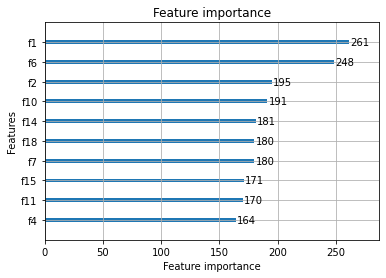

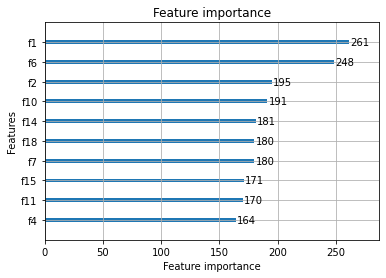

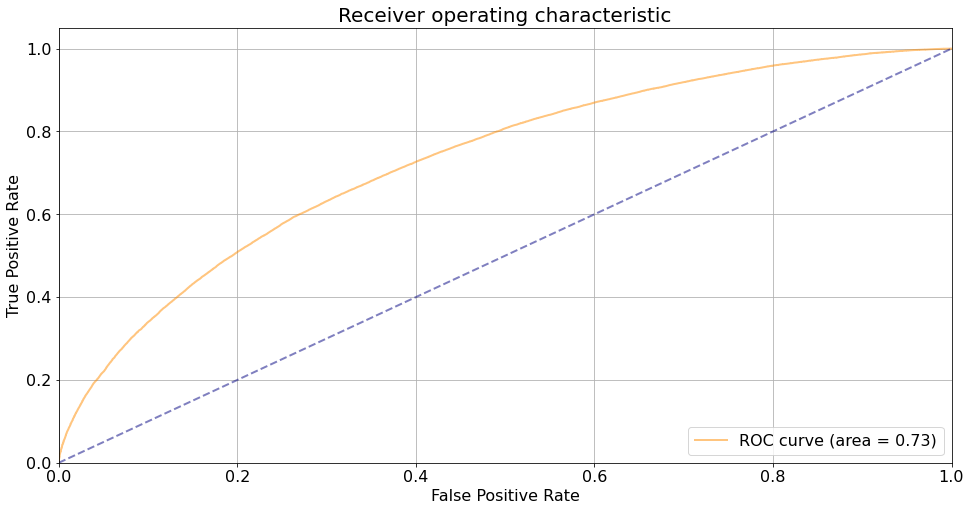

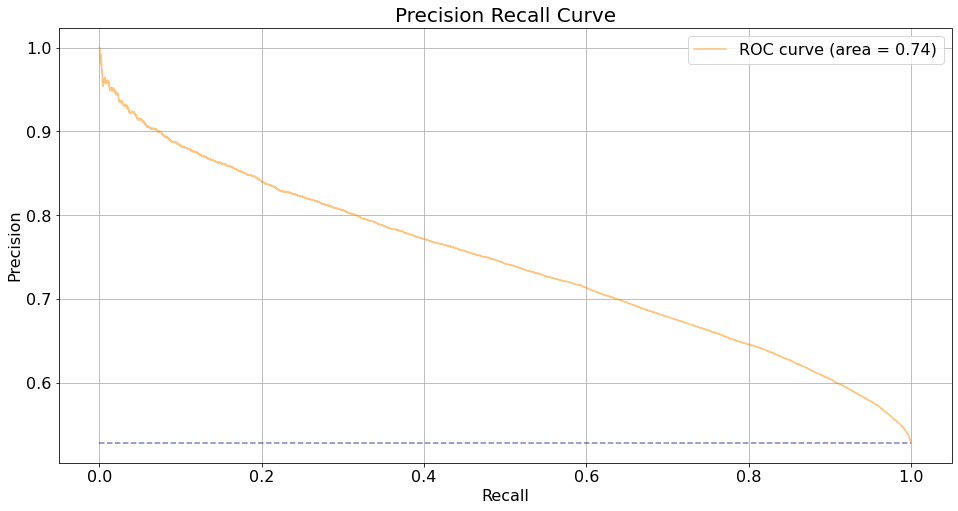

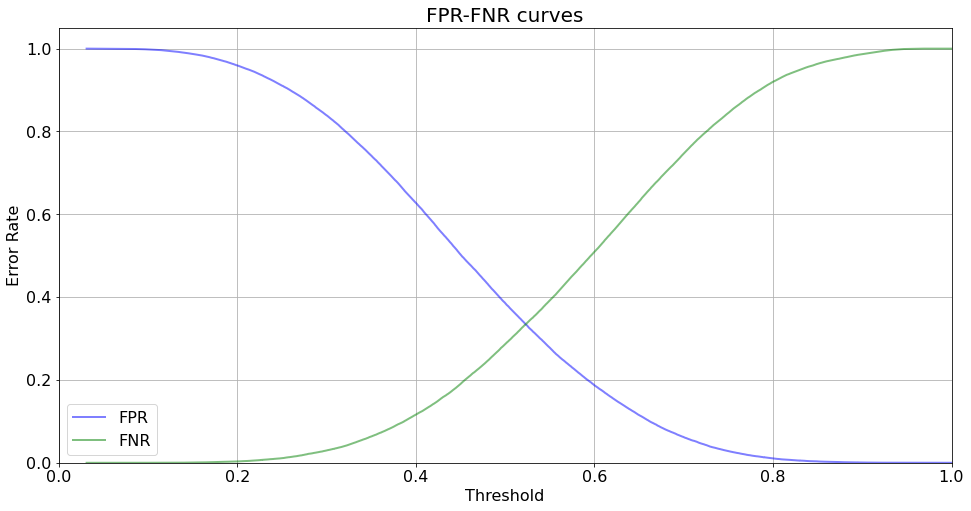

In [8]:
obj.train(train_X, train_y)
obj.evaluate()

In [2]:
!nvidia-smi

Tue May 26 20:38:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#upload the lgbm class
import lgbmclass as lgbc

In [0]:
obj = lgbc.Lgbmclass(train_X, train_y)

In [6]:
obj.train('hyperopt')

Running 5 rounds of LGBM parameter optimisation using Hyperopt:
100%|██████████| 5/5 [23:47<00:00, 285.43s/it, best loss: 0.16821754108057496]


{'bagging_freq': 2,
 'boosting_type': 'gbdt',
 'device': 'gpu',
 'feature_fraction': 0.7581060118675438,
 'lambda_l1': 0.7473985034480637,
 'lambda_l2': 0.9474156743939212,
 'learning_rate': 0.12372304135891532,
 'max_bin': 254,
 'min_data_in_leaf': 470,
 'n_estimators': 144,
 'num_leaves': 60,
 'objective': 'binary',
 'subsample': 0.8419830304755795,
 'subsample_for_bin': 220000,
 'verbosity': 0}

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:150: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Model will be trained with best parameters obtained from Hyperopt ... 



Model trained on the following parameters: 
{'bagging_freq': 2, 'boosting_type': 'gbdt', 'feature_fraction': 0.7581060118675438, 'lambda_l1': 0.7473985034480637, 'lambda_l2': 0.9474156743939212, 'learning_rate': 0.12372304135891532, 'max_bin': 254, 'min_data_in_leaf': 470, 'num_leaves': 60, 'objective': 'binary', 'subsample_for_bin': 220000, 'verbosity': 0, 'subsample': 0.8419830304755795, 'device': 'gpu', 'n_estimators': 1277}
Plotting feature importances...


array([0.75036354, 0.69724266, 0.86840554, ..., 0.13441534, 0.24934687,
       0.1371789 ])

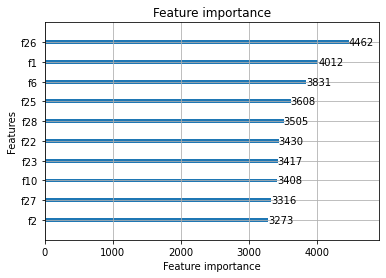

In [7]:
obj.test(train_X, train_y)

In [8]:
!nvidia-smi

Tue May 26 21:10:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  